Update summary figures in google doc: 
* https://docs.google.com/document/d/1D_CiAcmzooIv72WNvIO_g7VCmTlJd-88Hto95fcbmyg/edit

## MuscatReader class

In [1]:
%matplotlib inline

from muscatreader import MuscatReader

In [ ]:
mr = MuscatReader(obsdate=191029, 
                  objname='TOI516', 
                  objcoord=(112.382, 2.848), 
                  bands=['g','r','z_s'],
                  ref_frame=20,
#                   datadir='.',
                  photdir='apphot_mapping')

In [3]:
datasets = mr.save_as_nc(overwrite=True)

Saved: ./191029/TOI516_191029_g.nc
Saved: ./191029/TOI516_191029_r.nc
Saved: ./191029/TOI516_191029_z_s.nc


In [4]:
band = 'g'
ds = datasets[band]
ds

<xarray.Dataset>
Dimensions:        (aperture: 13, axis: 2, centroid_pix: 2, centroid_sky: 2, frame: 90, mjd: 90, quantity: 3, star: 10)
Coordinates:
  * mjd            (mjd) float64 5.879e+04 5.879e+04 ... 5.879e+04 5.879e+04
  * aperture       (aperture) float64 4.0 8.0 12.0 20.0 ... 36.0 40.0 45.0 50.0
  * star           (star) int64 1 2 3 4 5 6 7 8 9 10
  * axis           (axis) <U1 'x' 'y'
  * quantity       (quantity) <U7 'airmass' 'exptime' 'mjd'
  * centroid_pix   (centroid_pix) <U1 'x' 'y'
  * centroid_sky   (centroid_sky) <U3 'ra' 'dec'
Dimensions without coordinates: frame
Data variables:
    flux           (mjd, star, aperture) float64 1.448e+06 ... 1.003e+06
    obj_entropy    (mjd, star, aperture) float64 5.22 7.21 6.71 ... 5.08 4.98
    sky_median     (mjd, star) float64 1.849e+03 1.844e+03 ... 1.012e+03
    sky_entropy    (mjd, star) float64 5.885e+04 6.35e+04 ... 3.051e+04
    centroid       (mjd, star, axis) float64 519.9 628.7 333.7 ... 204.6 943.9
    aux           

## test transit modeling

In [5]:
from muscat2ta.tfopanalysis import TFOPAnalysis

In [6]:
#only guesses for now
TID=0
CIDS=[1,2,3,4,5,6,7,8,9]

In [7]:
from astropy.time import Time

ta = TFOPAnalysis(target='TOI516', 
                  date='191029', 
                  tid=TID, 
                  cids=CIDS, 
                  dataroot='.', 
#                   mjd_start=Time(245876.23, format='jd').mjd,
#                   mjd_end=inf,
#                   excluded_mjd_ranges=[#(Time(2458786.225, format='jd').mjd,
#                                        #Time(2458786.224, format='jd').mjd)
#                                       (58785.72,
#                                        58785.745)
#                                       ],
                  aperture_lims=(0, 9),
                  passbands=('g', 'r', 'z_s'),
                  use_opencl=True,
                  with_contamination=False,
                  radius_ratio='achromatic',
#                   excluded_stars=(8,10)
                 )

In [8]:
#tc, period come from TOI releases
ta.lpf.ps

[  0 |G| tc             N(μ = 0.24402400013059378, σ = 0.0204620184976947) [    -inf ..      inf],
   1 |G| p              N(μ = 1.04855, σ = 7.3e-05)              [    0.00 ..      inf],
   2 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..     1.00],
   4 |P| k2             U(a = 0.008661238281249999, b = 0.13857981249999998) [    0.00 ..     0.06],
   5 |P| q1_0           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   6 |P| q2_0           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   7 |P| q1_1           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   8 |P| q2_1           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   9 |P| q1_2           U(a = 0, b = 1)                          [    0.00 ..     1.00],
  10 |P| q2_2           U(a = 0, b = 1)                          [    0.00 ..     1.00],

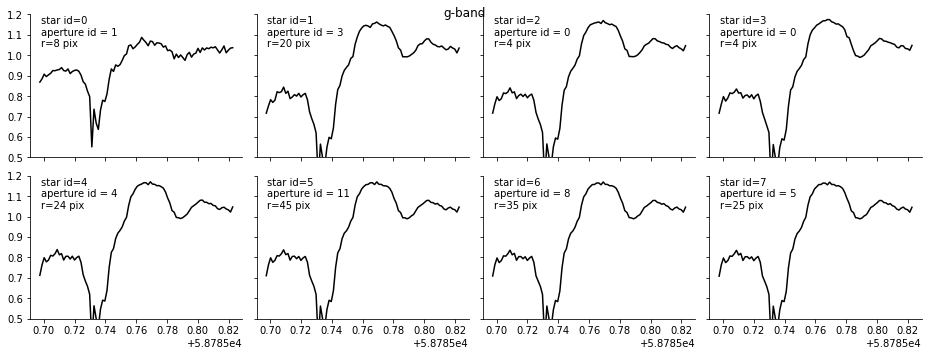

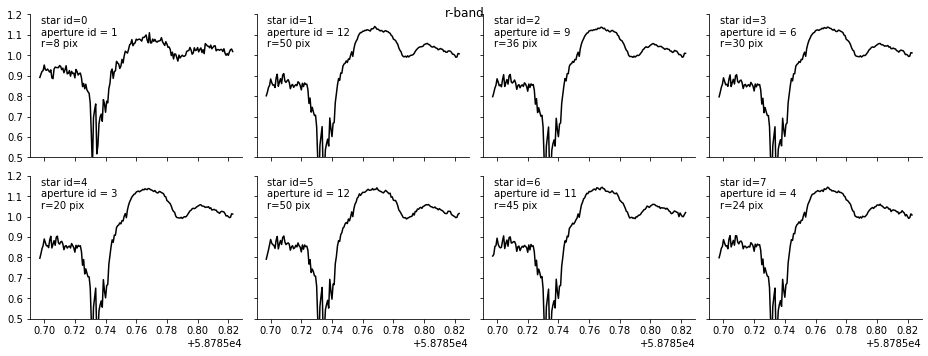

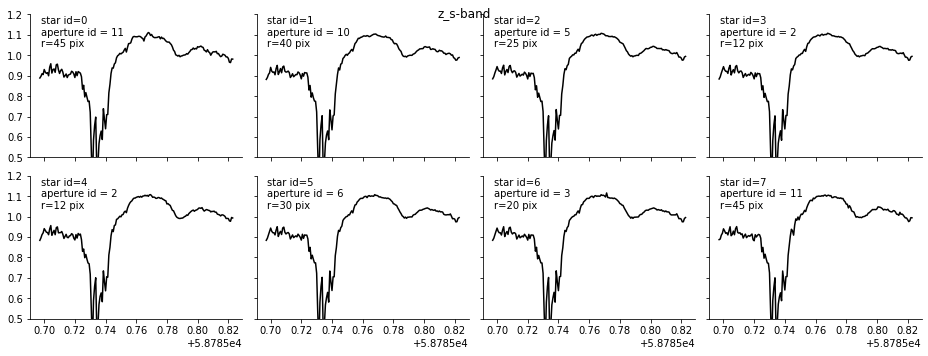

In [9]:
for ph,band in zip(ta.phs,ta.passbands):
    fig = ph.plot_raw(8, figsize=(13,5), 
                     ylim=(0.5, 1.2)
                     );
    fig.suptitle(f'{band}-band')

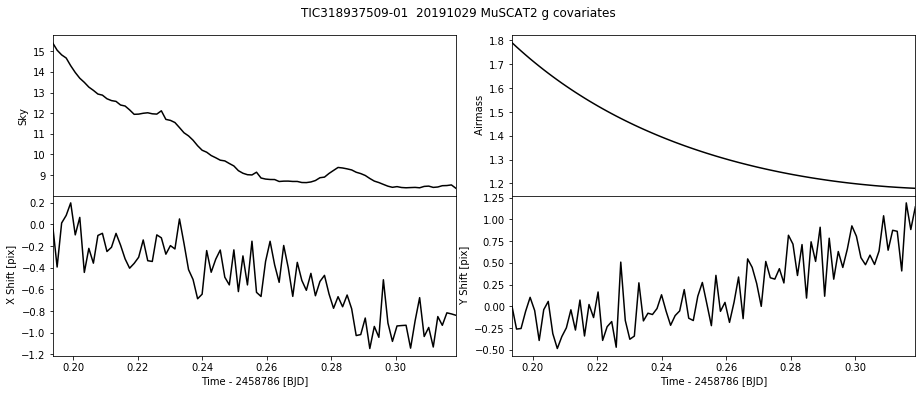

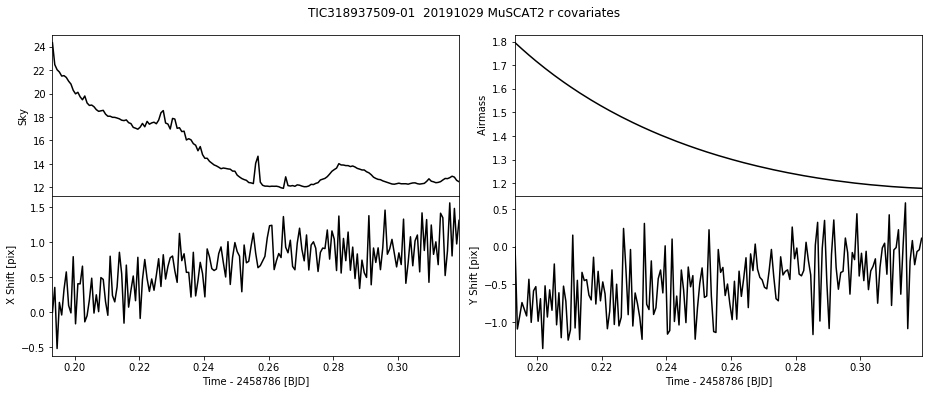

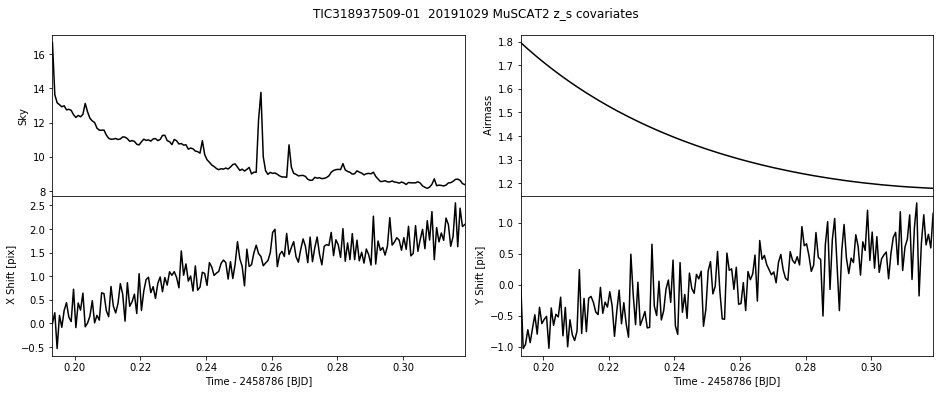

In [10]:
ta.plot_covariates()

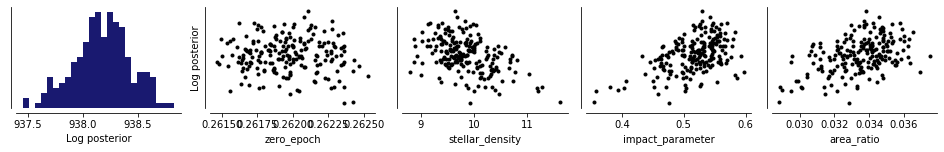

In [11]:
ta.optimize(3000)

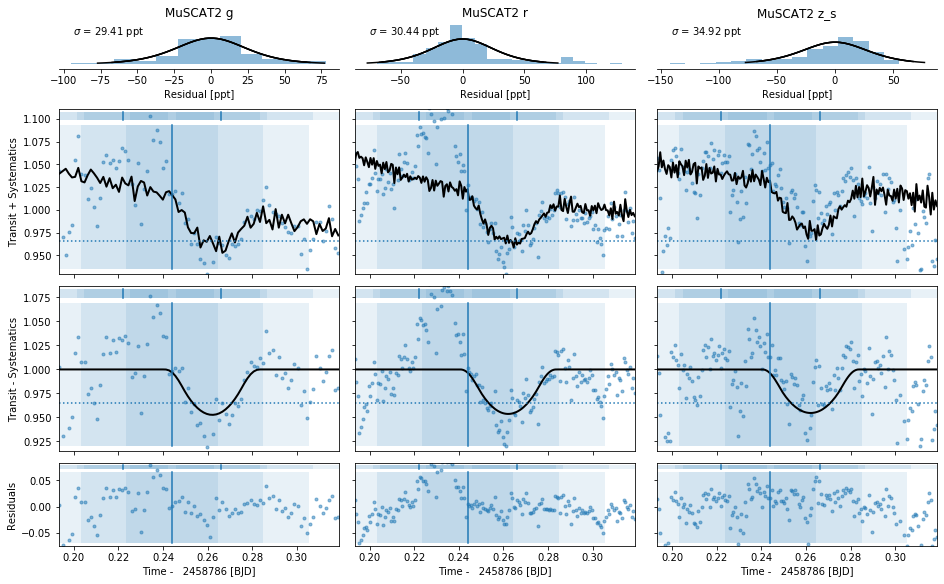

In [12]:
fig = ta.plot_fit('de');

In [25]:
ta.freeze_photometry()

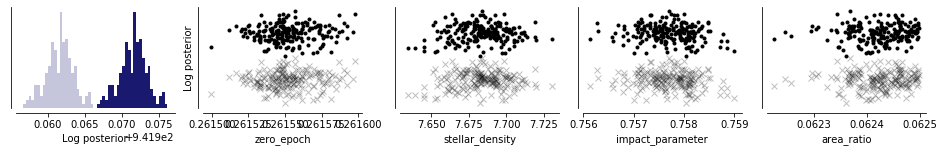

In [26]:
ta.optimize(500)

In [27]:
ta.sample(niter=5000, repeats=2)

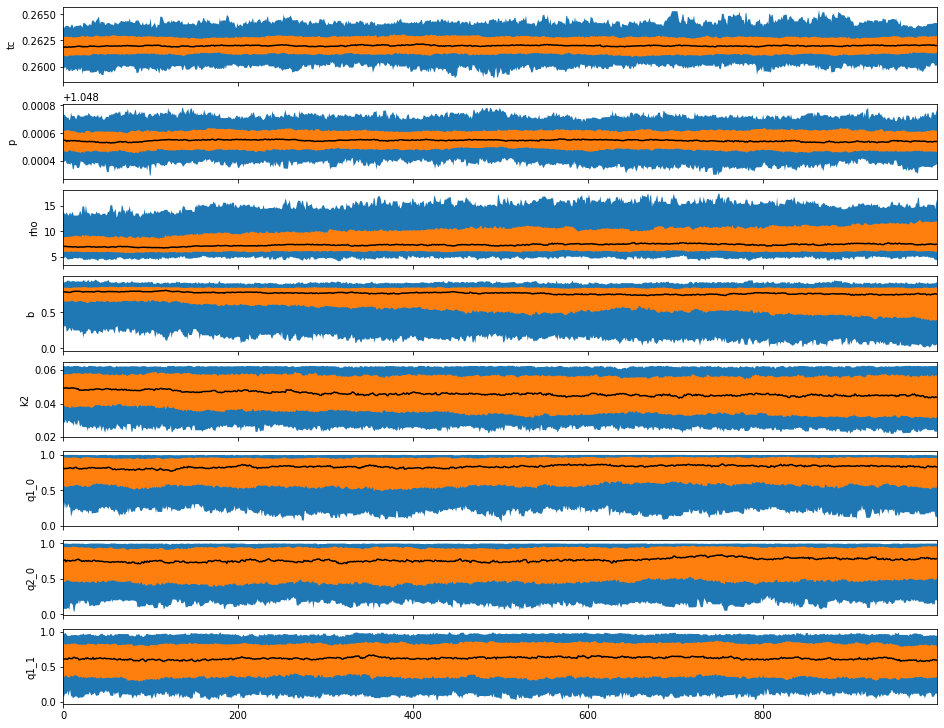

In [28]:
ta.lpf.plot_chains(pids=range(8))

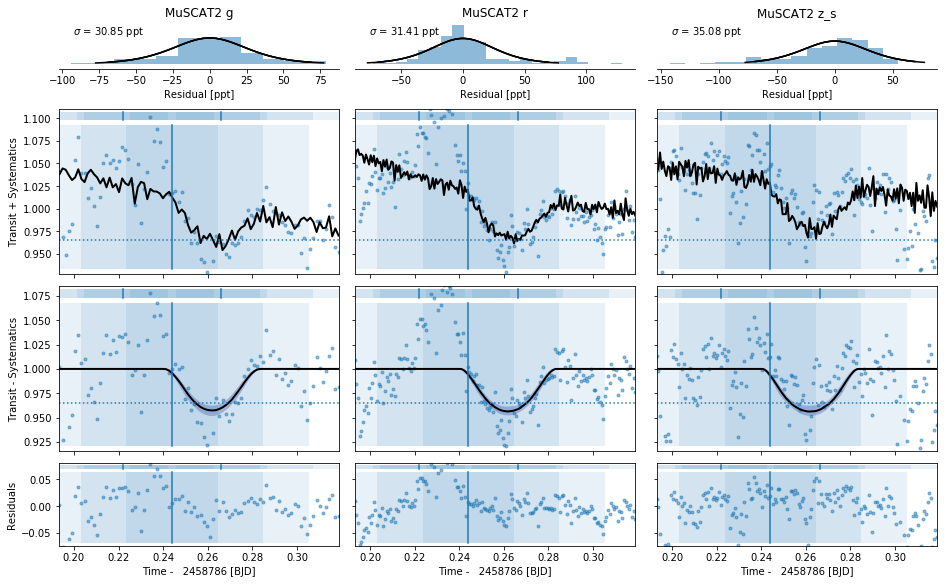

In [29]:
fig = ta.plot_fit('mc');

In [30]:
import numpy as np

df = ta.posterior_samples()
k2cols = [c for c in df.columns if 'k2' in c]
for c in k2cols:
    df[c.replace('k2', 'k')] = np.sqrt(df[c])
    df.drop(c, axis=1, inplace=True)

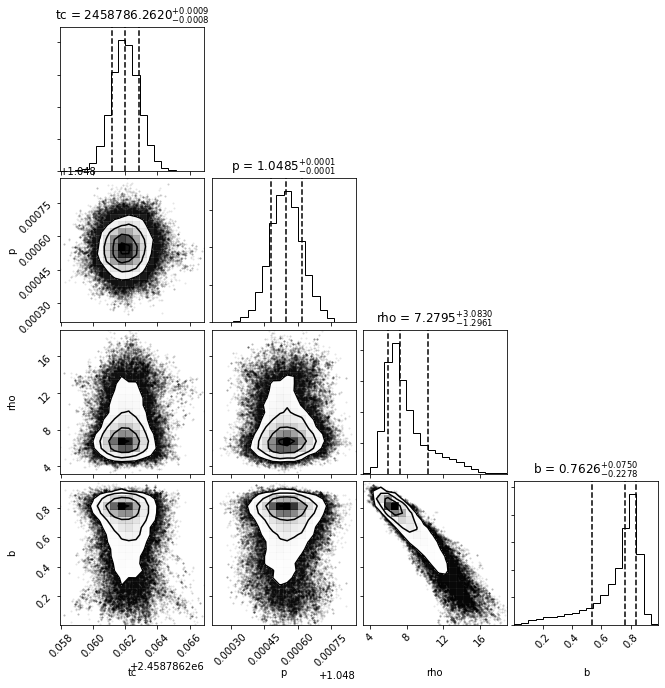

In [31]:
from corner import corner

fig = corner(df[df.columns[:4]], show_titles=True,
       title_fmt='.4f',
       quantiles=[0.16,0.5,0.84]);

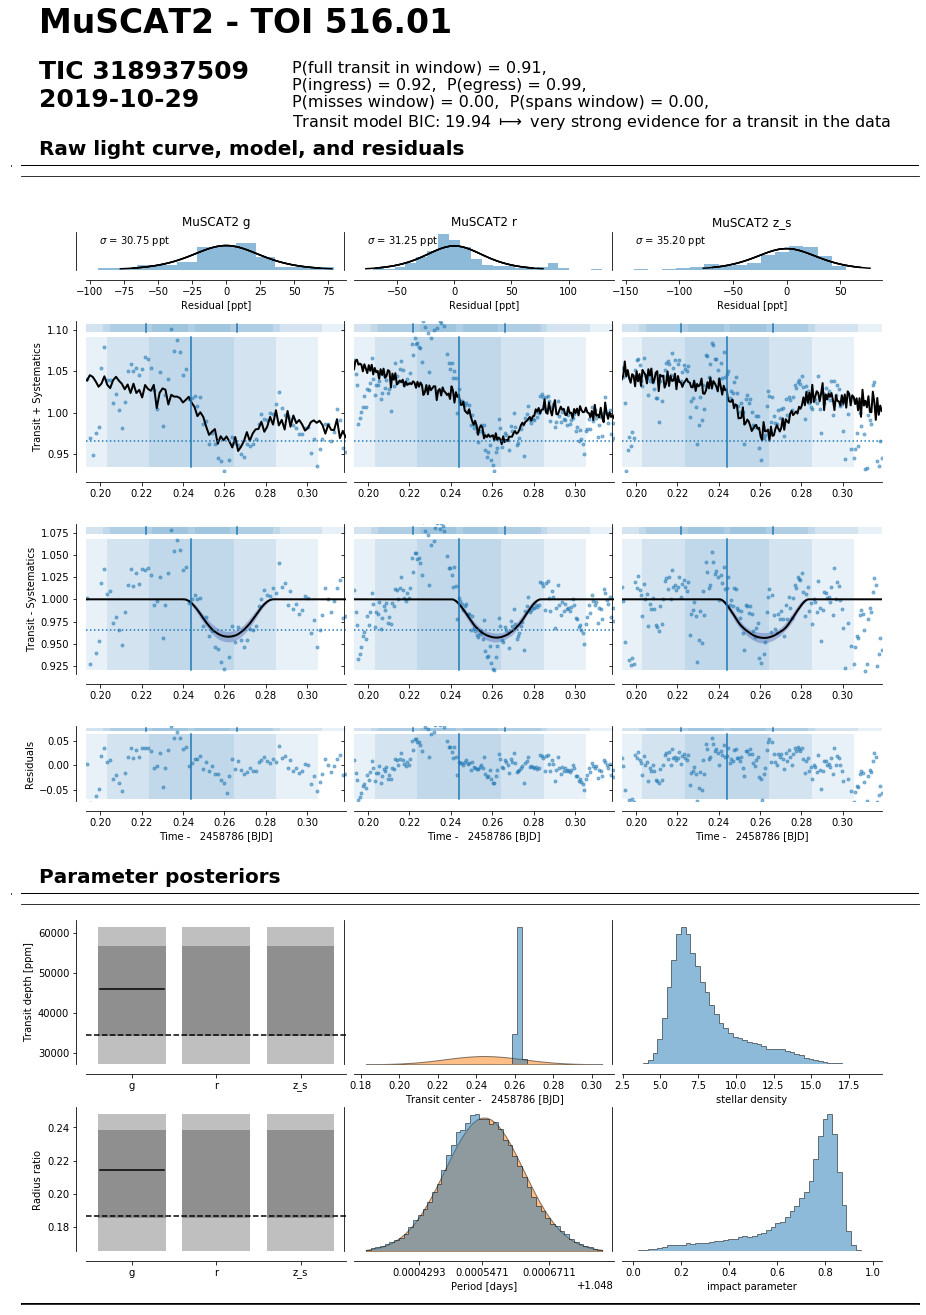

In [32]:
fig = ta.plot_final_fit();

In [110]:
ta.export_tables()